<a href="https://colab.research.google.com/github/sangeethapk/AI-ML/blob/main/Unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Imports and helpers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA



##Load data

In [2]:
# 2. load dataset
df=pd.read_csv("/content/Wholesale customers data.csv")
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


##Skewness

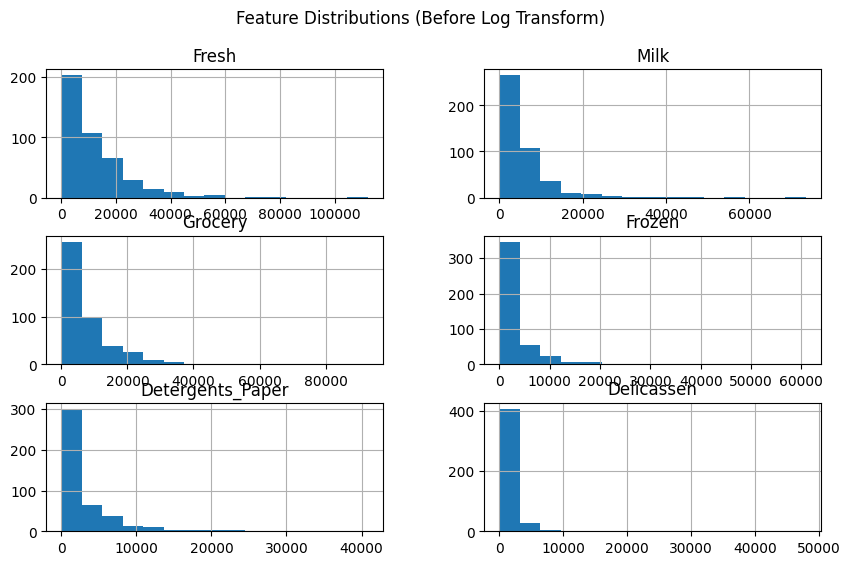

In [3]:
import matplotlib.pyplot as plt
df[["Fresh","Milk","Grocery","Frozen","Detergents_Paper","Delicassen"]].hist(bins=15, figsize=(10,6))
plt.suptitle("Feature Distributions (Before Log Transform)")
plt.show()


In [4]:
#Apply log
# 3. Features and preprocessing
features = ["Fresh","Milk","Grocery","Frozen","Detergents_Paper","Delicassen"]
X_raw = df[features].copy()

# log(1+x) to reduce skew, then standardize
X_log = np.log1p(X_raw)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

# quick check
print("shape:", X_scaled.shape)
print("feature means (after scaling):", X_scaled.mean(axis=0).round(3))


shape: (440, 6)
feature means (after scaling): [ 0. -0. -0.  0. -0. -0.]


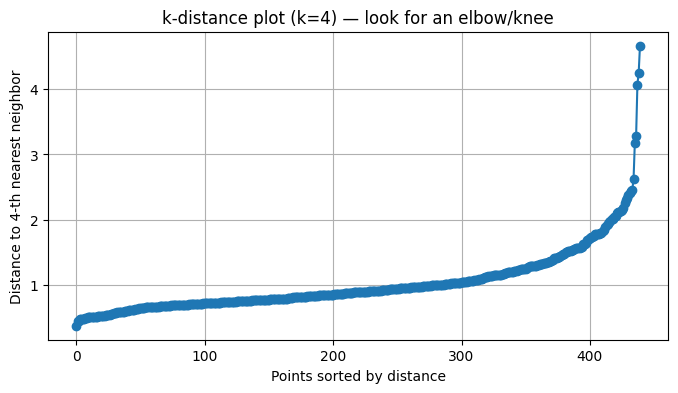

In [5]:
#k-distance plot to choose eps
# 4. k-distance plot (helps pick eps)
min_samples = 4   # try 3-5 for this small sample
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
k_distances = np.sort(distances[:, -1])   # distance to k-th nearest neighbor

plt.figure(figsize=(8,4))
plt.plot(k_distances, marker='o')
plt.title(f'k-distance plot (k={min_samples}) — look for an elbow/knee')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'Distance to {min_samples}-th nearest neighbor')
plt.grid(True)
plt.show()


In [6]:
# 5. Try candidate eps values (20th->80th percentile of k-distances)
eps_candidates = np.linspace(np.percentile(k_distances, 10),
                             np.percentile(k_distances, 90), 10)
results = []
for eps in eps_candidates:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    sil = np.nan
    if n_clusters > 1:
        try:
            sil = silhouette_score(X_scaled, labels)
        except:
            sil = np.nan
    results.append((eps, n_clusters, n_noise, sil))

# Print the candidate results
print("eps    clusters  noise   silhouette")
for eps, ncl, nnoise, sil in results:
    print(f"{eps:.4f}   {ncl:8d}  {nnoise:6d}  {np.nan if np.isnan(sil) else round(sil,4)}")


eps    clusters  noise   silhouette
0.6215          7     365  -0.3378
0.7328          9     259  -0.3435
0.8440          5     179  -0.2326
0.9553          3     124  0.0319
1.0665          1      93  nan
1.1778          2      75  0.0664
1.2890          1      55  nan
1.4002          1      47  nan
1.5115          1      39  nan
1.6227          1      32  nan


In [7]:
# 6. Run DBSCAN with chosen eps (edit eps_chosen below to one you prefer)
eps_chosen = float(results[len(results)//2][0])  # default: middle candidate; replace if you want
print("Using eps =", eps_chosen, "min_samples =", min_samples)

db = DBSCAN(eps=eps_chosen, min_samples=min_samples)
labels = db.fit_predict(X_scaled)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
print(f'Number of clusters: {n_clusters}')
print(f'Number of noise points: {n_noise}')

# Silhouette if defined
if n_clusters > 1:
    sil = silhouette_score(X_scaled, labels)
    print("Silhouette Score:", round(sil, 4))
else:
    print("Silhouette score not defined (need >1 cluster).")

# attach to df
df['DBSCAN_cluster'] = labels
print("\nCluster counts:\n", df['DBSCAN_cluster'].value_counts())


Using eps = 1.1777501001382822 min_samples = 4
Number of clusters: 2
Number of noise points: 75
Silhouette Score: 0.0664

Cluster counts:
 DBSCAN_cluster
 0    363
-1     75
 1      2
Name: count, dtype: int64


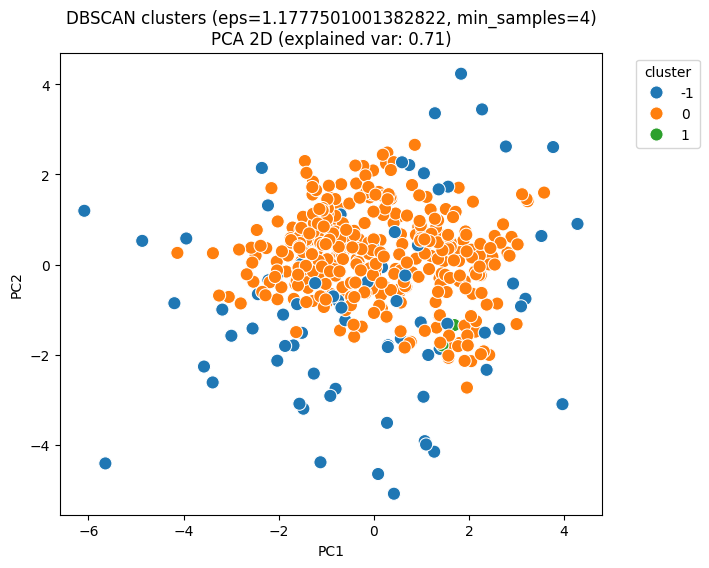

In [8]:
# 7. PCA visualization of clusters
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,6))
palette = sns.color_palette("tab10", n_colors=len(np.unique(labels)))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette=palette, s=90)
plt.title(f'DBSCAN clusters (eps={eps_chosen}, min_samples={min_samples})\nPCA 2D (explained var: {pca.explained_variance_ratio_.sum():.2f})')
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(title="cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
